In [ ]:
import torch              #Python statement used in PyTorch to import the neural network module.
import torch.nn as nn           #Python statement used in PyTorch to import the functional interface of the neural network module
import torch.nn.functional as F         #It allows you to use F as a shorthand for accessing various functions like activation functions, loss functions, and other utilities that are applied directly to tensors without defining a full layer.
from torchvision import datasets, transforms  #Python statement used in PyTorch to import the datasets and transforms modules from the torchvision library, Transforms: offers a variety of image transformation functions (e.g., resizing, normalization, and augmentation
from torch.utils.data import DataLoader # Python statement used in PyTorch to import the DataLoader class from the torch.utils.data module DataLoader is a utility class in PyTorch that helps in creating batches of data from a dataset
import matplotlib.pyplot as plt

In [ ]:
# specify values for some parameters needed in the VAE model and/or training loop:
Z_DIM = 20 #The dimensionality of the latent space, or the number of features in the encoded representation. These 20 features are not layers but a set of values that represent important aspects of the data.
BATCH_SIZE = 64 #The number of samples processed before the model's internal parameters are updated.
LEARNING_RATE = 0.001
NUM_EPOCHS = 2 #Epochs: Iterations; The no of times that entire training data set is passed.
TAU = 1.0  # temperature parameters for the Gumbel-Softmax VAE The initial temperature parameter for the Gumbel-Softmax, which controls the smoothness of the softmax output.
#When we talk about smoothness with the temperature parameter TAU, a higher temperature results in more smoothness, meaning the output probabilities are spread out more evenly and the model is less confident (more "soft" in its decisions).
#A lower temperature means the output is more peaked, making the model more confident and less smooth, more like a hard decision.
# So, smoothness is like how softly or smoothly the model can decide between different options.
TAU_DECAY = 0.95 # 0.95: The rate at which the temperature TAU decreases after each epoch
MIN_TAU = 0.1 #The minimum value that the temperature TAU can reach.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforming in Generative AI involves modifying data to create variations or new instances while preserving certain characteristics, ultimately enabling the generation of diverse and creative outputs.
# Below part is used for Data Preprocessing pipeline; The transforms.Compose([...]) is used to create a sequence of transformations that are applied to each sample in the dataset.
# By using transforms.Compose, we can apply multiple transformations sequentially, such as resizing, normalization, and data augmentation, in a consistent and efficient manner.
# Resizing the images from [28, 28] to [64, 64] increases the resolution and ensures that all images have the same size, making it easier to process them in a neural network.
# transforms.Compose just clubs all the transforms provided to it. So, all the transforms in the transforms.Compose are applied to the input one by one.
# The .ToTensor() function, often used in the context of PyTorch and its torchvision library, serves to convert images into tensor format

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # convert [28, 28] into [64, 64]
    transforms.ToTensor()
])


In [ ]:
# load existing dataset FashionMNIST into the program:
training_data = datasets.FashionMNIST(
    root="data",   # root is the path where the train/test data is stored,
    train=True,    # train specifies training or test dataset: this is training dataset
    download=True,
    transform=transform  # converts a PIL image or NumPy ndarray into a PyTorch tensor in the dimension that we specified
)

test_dataset = datasets.FashionMNIST(
    root="data",
    train=False,   # train specifies training or test dataset: this is testing dataset
    download=True,
    transform=transform
)

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
#The function DataLoader() is used to create iterators that provide efficient access to the data during training and testing,
#even after the data has been downloaded. We need
#it because, it provides batching, shuffling, paralled data loading, iterating over the data sets.

Batch size: torch.Size([64, 1, 64, 64])


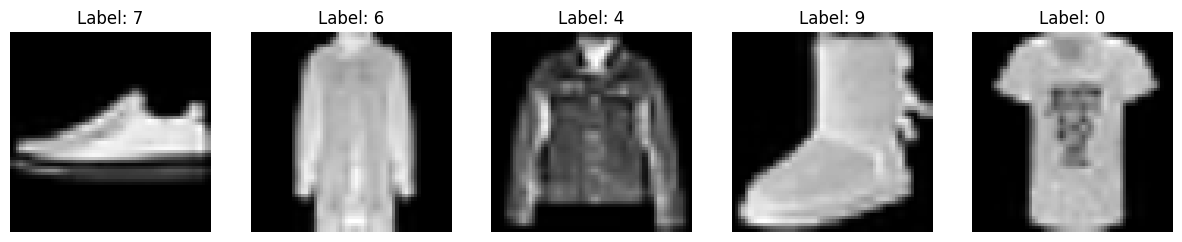

In [ ]:
# My Code to view how the images looks from train_loader variable.

import matplotlib.pyplot as plt

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print the size of the batch
print(f'Batch size: {images.size()}')  # This should print something like torch.Size([64, 1, 64, 64])

# Plot the first few images in the batch
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().squeeze()  # Convert to numpy array and remove the single channel dimension
    label = labels[i].item()
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()


In [ ]:
# copy the VAE model from our sample code: https://colab.research.google.com/drive/1a0J69FgvDwynn2CnBhJTUEtwRhr9HTy8?usp=sharing
# define a VAE with Gumbel Softmax distribution in latent spcae on MNIST



# In the provided code, batch normalization layers (nn.BatchNorm1d) are applied after each fully connected layer (nn.Linear).
# This means that batch normalization is applied to the outputs of the preceding fully connected layers.
# Batch normalization normalizes the activations across the batch dimension,
# which helps in stabilizing and accelerating the training process by reducing internal covariate shift and enabling faster convergence.


class GumbelVAE(nn.Module):
    def __init__(self):
        super(GumbelVAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(64 * 64, 512)
        self.fc_bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, Z_DIM)

        # Decoder layers
        self.fc4 = nn.Linear(Z_DIM, 256)
        self.fc_bn3 = nn.BatchNorm1d(256)
        self.fc5 = nn.Linear(256, 512)
        self.fc_bn4 = nn.BatchNorm1d(512)
        self.fc6 = nn.Linear(512, 64 * 64)

# Relu:  in PyTorch is a Rectified Linear Unit activation function, which applies the non-linearity
#𝑓(𝑥) = max(0,𝑥) f(x)=max(0,x) to introduce non-linearity into the model,  helping the network learn complex patterns.
#This line computes the output of the first fully connected layer (fc1) by applying the linear transformation to the input x.
#The output of fc1 is then passed through a batch normalization layer (fc_bn1) and then through a rectified linear unit (ReLU) activation function (F.relu).
#The ReLU activation function introduces non-linearity to the network, allowing it to learn complex patterns in the data.

    def encode(self, x):
        h1 = F.relu(self.fc_bn1(self.fc1(x)))
        h2 = F.relu(self.fc_bn2(self.fc2(h1)))
        return self.fc3(h2)

#In the provided code, F.gumbel_softmax(logits, tau=tau, hard=False) computes the Gumbel-Softmax distribution
#based on the input logits with a specified temperature parameter tau.

# hard=False: This parameter specifies whether to sample from the Gumbel-Softmax distribution (when hard=False) or
#use the one-hot representation directly (when hard=True). Setting hard=False means that the output will be a sample drawn from the Gumbel-Softmax distribution,
#while setting it to True would yield a one-hot representation.

# We need gumble softmax sitribution in encoding layer because Overall, the Gumbel-Softmax distribution in the encoding layer of models like VAEs provides a principled way to
#introduce stochasticity and differentiability, facilitating effective training and learning of meaningful latent representations of the input data.

    def reparameterize(self, logits, tau):
        z = F.gumbel_softmax(logits, tau=tau, hard=False)  # Gumbel Softmax distribution in latent spcae
        return z

    def decode(self, z):
        h3 = F.relu(self.fc_bn3(self.fc4(z)))
        h4 = F.relu(self.fc_bn4(self.fc5(h3)))
        return torch.sigmoid(self.fc6(h4))

#The first dimension -1 indicates that the batch size should be automatically inferred based on the original shape of x.
#This means that the number of images in the batch remains the same.
#The second dimension 64 * 64 represents the total number of elements in each flattened image vector. Since each image is 64x64 pixels,
#this dimension represents a 4096-element vector ^

    def forward(self, x, tau):
        logits = self.encode(x.view(-1, 64 * 64)) # x.view(-1, 64 * 64): each 64x64 image is converted into a flat 4096-element vector
        z = self.reparameterize(logits, tau)
        return self.decode(z), logits

#The loss function combines two parts:
#Reconstruction Loss (BCE): Measures how well the model can reconstruct the input data.
#Kullback-Leibler Divergence (KLD): Measures how closely the learned latent space distribution matches a prior distribution (usually a standard Gaussian).
#Purpose: Measures the difference between the original input x and the reconstructed output recon_x.
#The gumbel_vae_loss_function combines reconstruction and regularization terms to guide the training of a Gumbel-Softmax VAE.
#The reconstruction loss (BCE) ensures the output closely matches the input, while the KLD term regularizes the latent space to follow a standard Gaussian distribution.
#This combination helps the model learn meaningful and structured latent representations.

def gumbel_vae_loss_function0(recon_x, x, logits):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logits - logits.pow(2) - logits.exp())
    return BCE + KLD

def gumbel_vae_loss_function(recon_x, x, logits):
    # Clamp the values of recon_x between 0 and 1
    recon_x = torch.clamp(recon_x, 0, 1)
    # Binary cross entropy
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
    BCE /= x.size(0)  # Average over batch
    # KL divergence for Gumbel-Softmax
    # q_y is the probability, dim = -1 means using softmax on the last dimension
    q_y = F.softmax(logits, dim=-1)
    # retrict the range to avoid the log(0)
    q_y = torch.clamp(q_y, torch.finfo(q_y.dtype).eps, 1 - torch.finfo(q_y.dtype).eps)  # to prevent log(0)
    # Finding KL divergence
    KLD = torch.sum(q_y * torch.log(q_y * Z_DIM), dim=-1).sum()
    return BCE + KLD

def train_gumbel_vae(model, optimizer, data_loader, tau):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(DEVICE)  #Transfers the batch of data to the specified device (CPU or GPU).
        optimizer.zero_grad()   #Clears the gradients of all optimized tensors to prepare for the backward pass.
        recon_batch, logits = model(data, tau)  #Passes the data through the model, producing the reconstructed batch (recon_batch) and the logits (uncalibrated predictions).
        loss = gumbel_vae_loss_function(recon_batch, data, logits)
        loss.backward() #Computes the gradient of the loss with respect to the model parameters (Backward)
# .item() -> It's useful when you have a tensor containing only one value (e.g., a loss value) and you want to convert it to a Python number for further processing or printing.
        train_loss += loss.item()
        optimizer.step() # The gradient itself is taking the next step
    avg_loss = train_loss / len(data_loader.dataset)
    return avg_loss


def test_gumbel_vae(model, data_loader, tau):
    model.eval()
    test_loss = 0
    with torch.no_grad(): #block, gradient calculation is disabled, so z is computed without tracking gradients.
        for data, _ in data_loader:
            data = data.to(DEVICE)
            recon_batch, logits = model(data, tau)
            test_loss += gumbel_vae_loss_function(recon_batch, data, logits).item()
    avg_loss = test_loss / len(data_loader.dataset)
    return avg_loss

In [ ]:
# train the Gubmel Softmax VAE:
#Initializing the instance Gumble VAE class, .to(DEVICE) -> Moves model to the specified device, either CPU or GPU.
# torch.optim.Adam:  This initializes the Adam optimizer. Adam (Adaptive Moment Estimation) is a popular optimization algorithm that adjusts the learning rate for each parameter
# based on estimates of first and second moments of the gradients.
# gumbel_vae = GumbelVAE().to(DEVICE): Creates an instance of the GumbelVAE model and moves it to the specified device (CPU or GPU).
#optimizer = torch.optim.Adam(gumbel_vae.parameters(), lr=LEARNING_RATE): Sets up the Adam optimizer with the model's parameters and a specified learning rate,
#preparing it for training the model.

gumbel_vae = GumbelVAE().to(DEVICE)
optimizer = torch.optim.Adam(gumbel_vae.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    train_loss = train_gumbel_vae(gumbel_vae, optimizer, train_loader, TAU)  # train the model
    test_loss = test_gumbel_vae(gumbel_vae, test_loader, TAU)                # see the performance based on the testing dataset
    print(f'Vamsidhar Vuddagiri: Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    TAU = max(TAU * TAU_DECAY, MIN_TAU)


Vamsidhar Vuddagiri: Epoch 1, Train Loss: 13.3037, Test Loss: 12.8458
Vamsidhar Vuddagiri: Epoch 2, Train Loss: 12.5823, Test Loss: 12.5232


Vamsidhar Vuddagiri: plotting 20 images on the first row and their reconstructed images on the 2nd row:


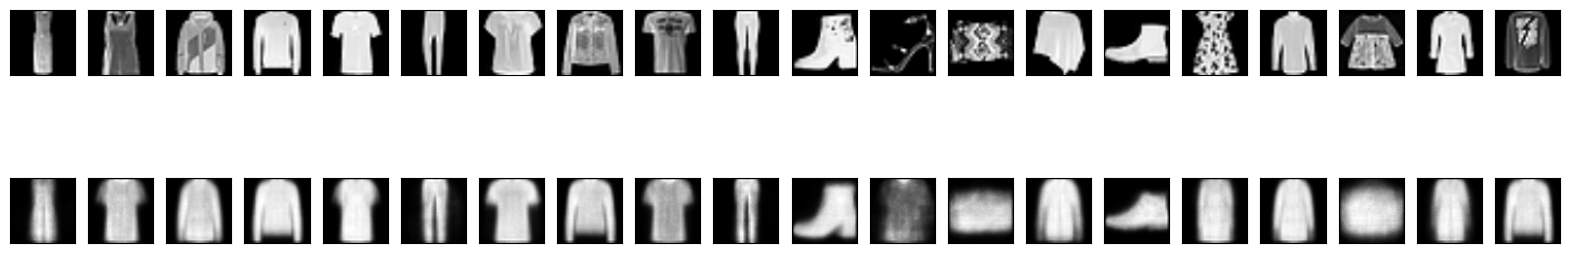

The MSE of Image 1 is:0.012707333080470562
The MSE of Image 2 is:0.028959186747670174
The MSE of Image 3 is:0.025416722521185875
The MSE of Image 4 is:0.020138544961810112
The MSE of Image 5 is:0.02566184476017952
The MSE of Image 6 is:0.021247854456305504
The MSE of Image 7 is:0.03439152240753174
The MSE of Image 8 is:0.025412283837795258
The MSE of Image 9 is:0.01583784446120262
The MSE of Image 10 is:0.029691224917769432
The MSE of Image 11 is:0.030583541840314865
The MSE of Image 12 is:0.018751319497823715
The MSE of Image 13 is:0.0403093658387661
The MSE of Image 14 is:0.05379163846373558
The MSE of Image 15 is:0.02533365599811077
The MSE of Image 16 is:0.04750300943851471
The MSE of Image 17 is:0.022394686937332153
The MSE of Image 18 is:0.028791122138500214
The MSE of Image 19 is:0.03884364292025566
The MSE of Image 20 is:0.10363703966140747


In [ ]:
# use the trained model to reconstruct data in the testing dataset:
loss = nn.MSELoss()
data, _ = next(iter(test_loader))  # get one batch of samples in the test_loader
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _ = gumbel_vae(data, TAU)

# def plot_images(original_images, reconstructed_images, n=20):
def plot_images(original_images, reconstructed_images, n=20):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # First row: Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i][0].cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Second row: Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = reconstructed_images[i].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

    for i in range(n):
      print(f'The MSE of Image {i+1} is:{(loss(original_images[i][0].cpu(),reconstructed_images[i].view(64, 64).cpu())).item()}' )



# Plot 20 images. You can see Gumbel-Softmax VAE can reconstruct data correctly with some accuracy
print("Vamsidhar Vuddagiri: plotting 20 images on the first row and their reconstructed images on the 2nd row:")
plot_images(data.cpu(), recon_batch.cpu(), n=20)

In [ ]:
# 30 points: Your task 1: Compute the MSE (mean squred error) between the pixels (i.e., elements in a 2D array) in the original images in the testing data and the pixels in the corresponding recontructed images.
# The MSE can be used to indicate the quality of reconstructed images. If MSE is smallers, the reconstructed images are more similar to original images. Print the MSE.
data_squeeze = data.view(data.size(0),-1)
recon_squeeze = recon_batch.view(recon_batch.size(0),-1)

loss = nn.MSELoss()
output = loss(data_squeeze.cpu(),recon_squeeze.cpu())
print(f'Output By Vamsidhar Vuddagiri: The MSE calculated from single batch of samples for GumbleVAE model:{output.item():.4f}')


def compute_mse(model,data_loader,tau):
  model.eval()
  total_mse_loss = 0
  with torch.no_grad():
    for data, _ in data_loader:             #Takes all batches of the samples in the test loader and calculates the MSE between test dataset and reconstructed images.
      data = data.to(DEVICE)
      recon_batch, _ = model(data,tau)
      data_squeeze = data.view(data.size(0), -1)
      recon_squeeze = recon_batch.view(recon_batch.size(0), -1)
      mse_loss = F.mse_loss(recon_squeeze, data_squeeze, reduction='sum')
      total_mse_loss += mse_loss.item()
    avg_mse_loss = total_mse_loss / len(data_loader.dataset)
    return avg_mse_loss



test_mse_loss = compute_mse(gumbel_vae, test_loader,TAU)
print(f'Output By Vamsidhar Vuddagir: MSE for the entire test dataset for GumbleVAE model: {test_mse_loss:.4f}')

Output By Vamsidhar Vuddagiri: The MSE calculated from single batch of samples for GumbleVAE model:0.0281
Output By Vamsidhar Vuddagir: MSE for the entire test dataset for GumbleVAE model: 113.8612


** Standard VAE using Gaussian distribution Latent Space **
**

In [ ]:
#30 points: Your task 2: Follow the sample code to build a VAE with a Gaussian distribution for the latent space. Train the model with 2 epoches and print the loss for each epoch.  Print the MSE.**
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
Z_DIM = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root = './data',
    train = True,
    transform = transform,
    download = True
)

test_dataset = datasets.FashionMNIST(
    root = './data',
    train = False,
    transform = transform,
    download = True
)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
class VAE(nn.Module): #This line defines a new class named VAE which inherits from nn.Module
  def __init__(self): #Initializing class
    super(VAE,self).__init__()

    #Encoder Layers
    self.fc1 = nn.Linear(64*64,512)
    self.fc_bn1 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(512, 256)
    self.fc_bn2 = nn.BatchNorm1d(256)
    self.fc21 = nn.Linear(256, Z_DIM) #Fully connected layer coming from fc2 to Z_DIM(latent space distribution)
    self.fc22 = nn.Linear(256, Z_DIM) #Another Fully connected layer coming from fc2 to Z_DIM(latent space distribution)

    #Decoder Layers
    self.fc3 = nn.Linear(Z_DIM,256)
    self.fc_bn3 = nn.BatchNorm1d(256)
    self.fc4 = nn.Linear(256, 512)
    self.fc_bn4 = nn.BatchNorm1d(512)
    self.fc5 = nn.Linear(512, 64 * 64)

  def encode(self,x):
    h1 = F.relu(self.fc_bn1(self.fc1(x)))
    h2 = F.relu(self.fc_bn2(self.fc2(h1)))
    return self.fc21(h2), self.fc22(h2) #these variables represent mean(mu) and log variance(logvar)

  # The log variance (logvar) is provided by the encoder network. To obtain the standard deviation, we exponentiate half of the logvar
  # torch.randn_like(std): Adding noise between(mean:0 and variance:1) with the same shape as std
  # We need noise because to avoid overfitting or underfitting, encouraging latent space to besmooth and continuos
  # The noise added to the standard deviation represents the inherent uncertainty and variability in the data. Without this noise, the model would always output the mean
  # 𝜇 , which would lead to a deterministic and less flexible model. Adding noise ensures that the model can generate diverse samples from the learned distribution.
  # This combines the mean (mu), the standard deviation (std), and the random noise (eps) to produce a sample from the Gaussian distribution. This is essentially the formula for sampling from a normal distribution

  def reparameterize(self,mu,logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  #torch.sigmoid(self.fc5(h4)) ensures that the output values are within the range [0, 1], making the output suitable for direct comparison with the input data during training (especially if the input data is normalized to this range).
  #By using the sigmoid function in the final layer, the VAE ensures that its output is properly scaled and can be interpreted as a probability distribution, which is essential for reconstructing normalized data like images.
  #The sigmoid function provides a smooth, non-linear transformation, which helps in learning complex patterns in the data. This non-linearity is crucial for the model to capture intricate details in the reconstruction task.

  def decode(self,z):
    h3 = F.relu(self.fc_bn3(self.fc3(z)))
    h4 = F.relu(self.fc_bn4(self.fc4(h3)))
    return torch.sigmoid(self.fc5(h4))

  # The forward method encodes the input, samples the latent vector using reparameterize,
  # and then decodes the latent vector back into the original space.
  def forward(self,x):
    mu, logvar = self.encode(x.view(-1, 64 * 64))
    z = self.reparameterize(mu, logvar)
    return self.decode(z), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x.view(-1, 64 * 64), reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD
# Training Model


def train_vae(model,optimizer,data_loader):
  model.train()
  train_loss = 0
  for batch_idx, (data,_) in enumerate(data_loader):
    data = data.to(DEVICE)
    optimizer.zero_grad()
    recon_batch_tr, mu, logvar = model(data)
    loss = vae_loss_function(recon_batch_tr,data,mu,logvar)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  avg_loss = train_loss/len(data_loader.dataset)
  return avg_loss

#Testing Model

def test_vae(model,data_loader):
  loss = nn.MSELoss()
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for data,_ in data_loader:
      data = data.to(DEVICE)
      recon_batch,mu,logvar = model(data)
      loss = vae_loss_function(recon_batch,data,mu,logvar)
      test_loss += loss
  avg_loss = test_loss/len(data_loader.dataset)
  return avg_loss


vae = VAE().to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(),lr = LEARNING_RATE)


for epoch in range(NUM_EPOCHS):
  train_loss = train_vae(vae, optimizer, train_loader)
  test_loss = test_vae(vae, test_loader)
  print(f'Output By Vamsidhar Vuddagiri: Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f} for VAE with a Gaussian distribution for the latent space.')

Output By Vamsidhar Vuddagiri: Epoch 1, Train Loss: 1372.3133, Test Loss: 1292.7297 for VAE with a Gaussian distribution for the latent space.
Output By Vamsidhar Vuddagiri: Epoch 2, Train Loss: 1275.9355, Test Loss: 1266.3987 for VAE with a Gaussian distribution for the latent space.


plotting 20 images on the first row and their reconstructed images on the 2nd row: 



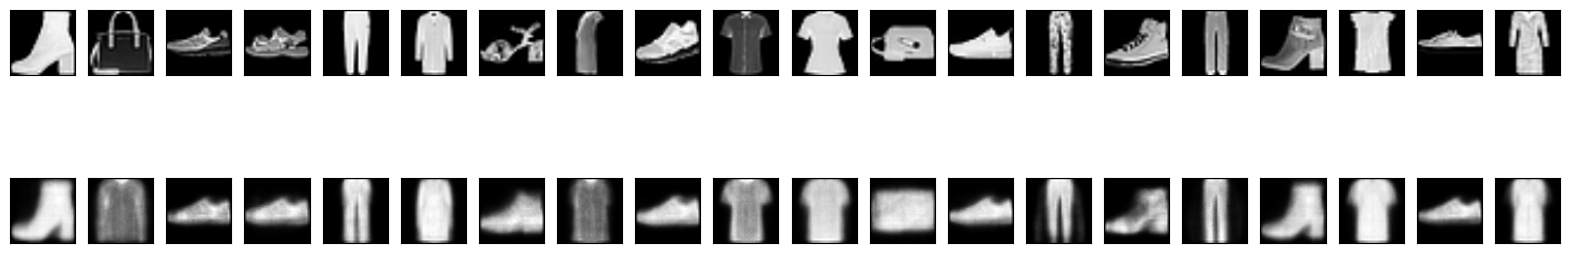



Output By Vamsidhar Vuddagiri: The MSE calculated from all batch of samples from training set for VAE with a Gaussian distribution for the latent space:40.2257
Output By Vamsidhar Vuddagiri: The MSE calculated from single batch of samples from the test set for VAE with a Gaussian distribution for the latent space:0.0267


In [ ]:
# use the trained model to reconstruct data in the testing dataset:
loss = nn.MSELoss()
data, _ = next(iter(test_loader))  # Takes only one batch of samples in the test_loader
data = data.to(DEVICE)
with torch.no_grad():
    recon_batch, _ = gumbel_vae(data, TAU)

# def plot_images(original_images, reconstructed_images, n=20):
def plot_images(original_images, reconstructed_images, n=20):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # First row: Display original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i][0].cpu(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Second row: Display reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        recon_image = reconstructed_images[i].view(64, 64).cpu()  # Reshape the tensor to 64x64
        plt.imshow(recon_image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    print('\n')

   # for i in range(n):
   # print(f'The MSE of Image {i+1} is:{(loss(original_images[i][0].cpu(),reconstructed_images[i].view(64, 64).cpu())).item()}' )

def compute_mse(model,data_loader):
  model.eval()
  total_mse_loss = 0
  with torch.no_grad():
    for data, _ in data_loader:             #Takes all batches of the samples in the test loader and calculates the MSE between test dataset and reconstructed images.
      data = data.to(DEVICE)
      recon_batch, _, _ = model(data)
      data_squeeze = data.view(data.size(0), -1)
      recon_squeeze = recon_batch.view(recon_batch.size(0), -1)
      mse_loss = F.mse_loss(recon_squeeze, data_squeeze, reduction='sum')
      total_mse_loss += mse_loss.item()
    avg_mse_loss = total_mse_loss / len(data_loader.dataset)
    return avg_mse_loss

print("plotting 20 images on the first row and their reconstructed images on the 2nd row: \n")
plot_images(data.cpu(), recon_batch.cpu(), n=20)

# Printing the MSE of only 1 batch of sample data from test dataset
data_squeeze = data.view(data.size(0),-1)
recon_squeeze = recon_batch.view(recon_batch.size(0),-1)


output = compute_mse(vae,train_loader)
print(f'Output By Vamsidhar Vuddagiri: The MSE calculated from all batch of samples from training set for VAE with a Gaussian distribution for the latent space:{output:.4f}')

loss = nn.MSELoss()
output = loss(data_squeeze.cpu(),recon_squeeze.cpu())
print(f'Output By Vamsidhar Vuddagiri: The MSE calculated from single batch of samples from the test set for VAE with a Gaussian distribution for the latent space:{output.item():.4f}')


In [ ]:
# 30 points: Your task 3: Using the VAE with Gaussian distribution for the latent space, compute the MSE (mean squred error) between the pixels in the original images in the testing data and the pixels in the corresponding recontructed images.
# The MSE can be used to indicate the quality of reconstructed images. If MSE is smallers, the reconstructed images are more similar to original images. Print the MSE.
def compute_mse(model,data_loader):
  model.eval()
  total_mse_loss = 0
  with torch.no_grad():
    for data, _ in data_loader:             #Takes all batches of the samples in the test loader and calculates the MSE between test dataset and reconstructed images.
      data = data.to(DEVICE)
      recon_batch, _, _ = model(data)
      data_squeeze = data.view(data.size(0), -1)
      recon_squeeze = recon_batch.view(recon_batch.size(0), -1)
      mse_loss = F.mse_loss(recon_squeeze, data_squeeze, reduction='sum')
      total_mse_loss += mse_loss.item()
    avg_mse_loss = total_mse_loss / len(data_loader.dataset)
    return avg_mse_loss



test_mse_loss = compute_mse(vae, test_loader)
print(f'Output By Vamsidhar Vuddagiri: The MSE calculated from all batch of samples for VAE with a Gaussian distribution for the latent space:{test_mse_loss:.4f}')

Output By Vamsidhar Vuddagiri: The MSE calculated from all batch of samples for VAE with a Gaussian distribution for the latent space:40.4960
